In [1]:
import qiskit as qk
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.options.sampler_options import SamplerOptions
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from pprint import pprint
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# See also https://docs.quantum.ibm.com/guides/primitives-examples 

```
PennyLane-qiskit                  0.36.0
qiskit                            1.1.0
qiskit-aer                        0.14.2
qiskit-algorithms                 0.3.0
qiskit-ibm-experiment             0.4.7
qiskit-ibm-runtime                0.23.0
qiskit-ionq                       0.5.1
qiskit-machine-learning           0.7.2
```




In [2]:
service = QiskitRuntimeService(name="olcf")
#service = QiskitRuntimeService(channel="ibm_quantum")
options = SamplerOptions()
options.default_shots=1000

In [9]:
#...!...!....................
def create_ghz_circuit(n):
    qc = qk.QuantumCircuit(n)
    qc.h(0)
    for i in range(1, n):  qc.cx(0, i)
    qc.measure_all()
    return qc
qc=create_ghz_circuit(4)
print(qc)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■────■────■───░─┤M├─────────
        └───┘┌─┴─┐  │    │   ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──┼────┼───░──╫─┤M├──────
             └───┘┌─┴─┐  │   ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──┼───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


### A) Run on real HW



In [5]:
backName='ibm_kyoto'
backend = service.get_backend(backName)

Here we create a pass manager based on the backend and then we run the pass manager on the virtual circuit to create the physical circuit ready to run

In [10]:
# transpiler(..) is now generate_preset_pass_manager(..)
mypass = generate_preset_pass_manager(backend=backend,optimization_level=3, seed_transpiler=44)
qcT = mypass.run(qc)

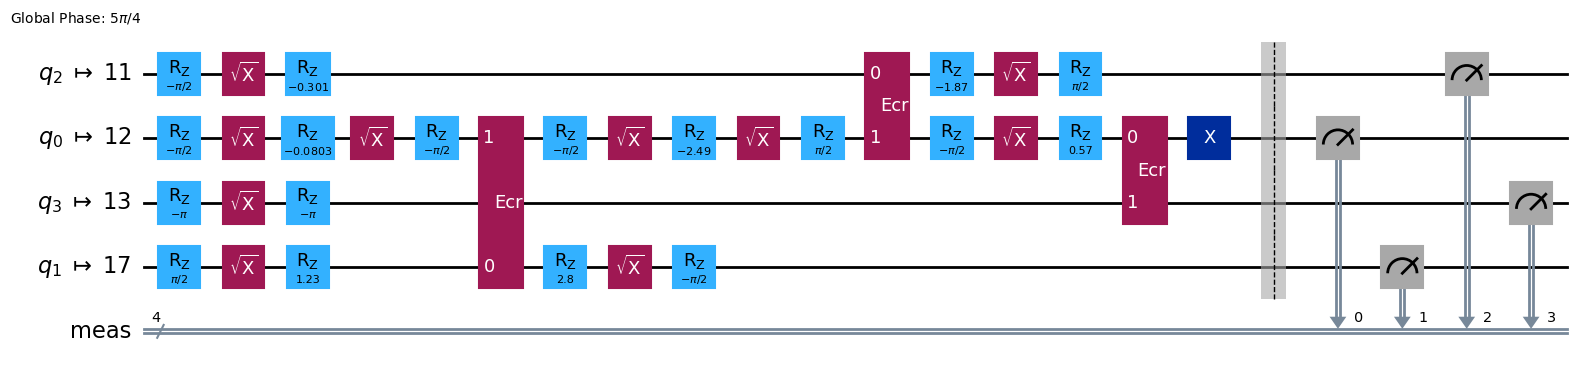

In [11]:
qcT.draw('mpl', idle_wires=False)

In [14]:
#qcT.draw('text', idle_wires=False)

In [15]:
qcEL=(qcT,)  # quant circ executable list
sampler = Sampler(backend=backend, options=options)
job = sampler.run(qcEL)
result=job.result()

In [16]:
pprint(result[0].data.meas.get_counts())

{'0000': 447,
 '0010': 18,
 '0100': 10,
 '0110': 1,
 '0111': 2,
 '1011': 22,
 '1101': 17,
 '1110': 1,
 '1111': 482}


### B) Run on fake backend

In [30]:
#backName='ibm_torino'
#backName='ibm_kyoto'
noisy_backend = service.get_backend(backName)
backend2 = AerSimulator.from_backend(noisy_backend)

qcT = qk.transpile(qc, backend=backend2, optimization_level=3)
print('use noisy_backend =', noisy_backend.name )

use noisy_backend = ibm_kyoto


transpiled CX-depth: 3


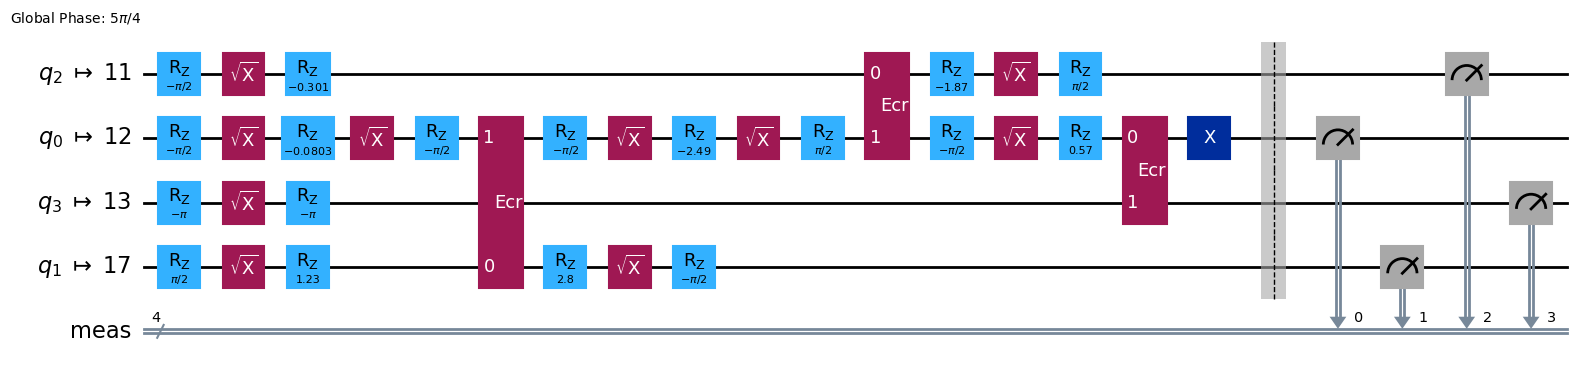

In [31]:
print('transpiled CX-depth:',qcT.depth(filter_function=lambda x: x.operation.num_qubits == 2 ))
#print(qcT.draw(output='text',idle_wires=False)) 
qcT.draw('mpl', idle_wires=False)

In [32]:
print('job started,  nq=%d  at %s ...'%(qcT.num_qubits,backend.name))
sampler = Sampler(backend=backend2, options=options)
job = sampler.run([qcT])
result=job.result()
jobMD=result.metadata    

job started,  nq=127  at ibm_kyoto ...


In [33]:
pprint(result[0].data.meas.get_counts())

{'0000': 461,
 '0001': 4,
 '0010': 6,
 '0100': 6,
 '0110': 1,
 '0111': 3,
 '1000': 3,
 '1001': 1,
 '1011': 3,
 '1101': 13,
 '1110': 2,
 '1111': 497}
